# Sahil Sheikh:        A20518693
# Gabriel Baranes:  A20521263

## Subject:CS 577
## Semester: FALL 22
## Deep Learning Project
CIFAR dataset of the project

In [1]:
import pandas as pd
import tensorflow as tf
import keras
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from keras.layers import Input, Add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, ZeroPadding2D, ReLU, Add, Input
from tensorflow.keras.datasets import cifar10
from keras.backend import resize_images
from sklearn.model_selection import train_test_split
import cv2

Creating a load data function to load and pre-process the cifar dataset which accepts Scale as a parameter, so we can upscale the image to our desired scale factor

In [2]:
def load_cifar(scale_f):
    
    (train_x,train_y),(test_x,test_y)= cifar10.load_data()
    class_label = ['airplane','automobile','bird','cat','deer','dog','frog', 'horse','ship','truck']
    i = np.random.randint(train_x.shape[0])

    plt.imshow(train_x[i])
    plt.axis('off')
    plt.title(class_label[train_y[i][0]])
    plt.show()

    train_label = train_x #Storing the original resoltuion img as train label
    test_label = test_x #Storing the original resoltuion img as test label
    
    print("Training set ground truth has shape: " + str(train_label.shape))
    print("Test set ground truth has shape: " + str(test_label.shape))
    
    #setting output width x height
    w,h = train_label.shape[1:-1]
    input_dim = train_label.shape[1:]
    scale_factor = scale_f
    #size_output_img = (w,h)
    print('Width and Height of training and test data should be:',input_dim)
    dw= int(w/scale_factor)
    dh=int(h/scale_factor)
    #print('Scale factor of for width and height:',dw,dh)
    ds =(dw,dh)
    
    #Creating Train_X and Test_X from the ground truth 
    #this is done so by reducing the size of copy of ground truth(train_label, test_label)
    #Here the scale is 2, the training shape = 16x16x3 i.e half of 32x32x3
    train_data = []
    for img in train_label:
        img_re = cv2.resize(img, ds, interpolation=cv2.INTER_CUBIC)
        train_data.append(img_re)
    train_data = np.asarray(train_data)

    test_data = []
    for img in test_label:
        img_re = cv2.resize(img,ds, interpolation=cv2.INTER_CUBIC)
        test_data.append(img_re)

    test_data = np.asarray(test_data)

    print("Training set has shape: " + str(train_data.shape))
    print("Test set has shape: " + str(test_data.shape))
    #plotting the images to see the progress we made uptil now.
    i = np.random.randint(train_data.shape[0])

    fig, ax = plt.subplots(1,2)
    fig.set_size_inches(12,6)
    fig.set_facecolor('w')

    ax[0].imshow(train_data[i])
    ax[0].set_title('X- input image[Low Resolution ]: For the model', fontsize=14)
    ax[0].axis('off')

    ax[1].imshow(train_label[i])
    ax[1].set_title('Y - Label output[High Resolution :]', fontsize=14)
    ax[1].axis('off')

    plt.axis('off')
    plt.show()
    
    print('We can the see difference in the images as img on left(Low Resolution) is half the size of one on right.')
    print('We will need to upscale the image to create the interpolated low resoltuion image to be feed into the network')
    print('Left Image size:',train_data.shape)
    print('Right Image size',train_label.shape)
    #normalizing the data and labels
    train_data = train_data/255.0
    train_label = train_label/255.0
    test_data = test_data/255.0
    test_label = test_label/255.0
    
    #Before I tried to convert the entire training data into a tensor but ran out of space
    # To counter this I divided the data into 5 batches, converted each batch to tensor
    # and finally concatinated these tensors to one single tensp=or which would hold all out training data(50,000 images)
    #train_data = np.array(train_data,dtype=float)
    b1 = train_data[:10000]
    b2 = train_data[10000:20000]
    b3 = train_data[20000:30000]
    b4 = train_data[30000:40000]
    b5 = train_data[40000:50000] 
    b1 = tf.convert_to_tensor(b1,dtype=float)
    b1 = resize_images(b1,scale_factor,scale_factor,'channels_last',interpolation='bilinear')
    b2 = tf.convert_to_tensor(b2,dtype=float)
    b2 = resize_images(b2,scale_factor,scale_factor,'channels_last',interpolation='bilinear')
    b3 = tf.convert_to_tensor(b3,dtype=float)
    b3 = resize_images(b3,scale_factor,scale_factor,'channels_last',interpolation='bilinear')
    b4 = tf.convert_to_tensor(b4,dtype=float)
    b4 = resize_images(b4,scale_factor,scale_factor,'channels_last',interpolation='bilinear')
    b5 = tf.convert_to_tensor(b5,dtype=float)
    b5 = resize_images(b5,scale_factor,scale_factor,'channels_last',interpolation='bilinear')
    x_scaled_train= tf.concat([b1,b2,b3,b4,b5],0)
    test_data = tf.convert_to_tensor(test_data,dtype=float)
    #x_scaled_train = resize_images(train_data,scale_factor,scale_factor,'channels_last',interpolation='bilinear')
    # the above line was not executable as i was unable to directly convert training data into due to memory issues
    x_scaled_test = resize_images(test_data,scale_factor,scale_factor,'channels_last',interpolation='bilinear')
    # Checking the train_x and train_y before training 

    fig, ax = plt.subplots(1,2)
    fig.set_size_inches(12,6)
    fig.set_facecolor('w')

    ax[0].imshow(x_scaled_train[0])
    ax[0].set_title('X- input image[Low Resolution ]: For the model', fontsize=14)
    ax[0].axis('off')

    ax[1].imshow(train_label[0])
    ax[1].set_title('Y - Label output[High Resolution :]', fontsize=14)
    ax[1].axis('off')

    plt.axis('off')
    plt.show()
    #Creating a validation dataset by slicing the trainig data
    x_train = x_scaled_train[:40000]
    x_vali = x_scaled_train[40000:]
    y_train = train_label[:40000]
    y_vali = train_label[40000:]
    print('After upscaling the input images:')
    print('Train data shape:',x_train.shape)
    print('Train label shape:',y_train.shape)
    print('Vali data shape:',x_vali.shape)
    print('Vali label shape:',y_vali.shape)
    print('Test data shape:',x_scaled_test.shape)
    print('Test label shape:',test_label.shape)
    
    return x_train,y_train,x_vali,y_vali,x_scaled_test,test_label


Creating a function to create the model

In [3]:
def vdsr(input_dim, l):
    LR = Input(shape=input_dim, name='input')
    X = ZeroPadding2D()(LR)
    X = Conv2D(64,(3,3), name='CONV1')(X)
    X = ReLU()(X)
    
    for i in range(l-2):
        X = ZeroPadding2D()(X)
        X = Conv2D(64, (3,3), name='CONV%i' % (i+2))(X)
        X = ReLU()(X)
    
    X = ZeroPadding2D()(X)
    residual = Conv2D(1, (3,3), name='CONV%i' % l)(X)
    
    out = Add()([LR, residual])
    
    return Model(LR, out)
        
    

Defining a plot function to plot graph

In [4]:
def plot(history):
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.legend()
    plt.show()
    
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend()
    plt.show()

Function to calculate PSNR for y_true and y_prediction

In [5]:
from math import log10, sqrt
import cv2
import numpy as np
  
def PSNR(y_true, y_pred):
    
    psnr_val = []
    for i in range(len(y_true)):
        mse = np.mean((y_true[i]-y_pred[i]) ** 2)
        if(mse == 0):
            psnr_val.append(100.0)
        else:
            max_pixel = 255.0
            psnr_val.append(20*log10(max_pixel/sqrt(mse)))
        
    return psnr_val

    #used the logic of this code to calculate psnr values
    #mse = np.mean((original - compressed) ** 2)
    #if(mse == 0):  -- MSE is zero means no noise is present in the signal .
                  #-- Therefore PSNR have no importance.
       # return 100
    #max_pixel = 255.0
    #psnr = 20 * log10(max_pixel / sqrt(mse))
    #return psnr

Ploting the values of PSNR for all predicted images

In [6]:
def plot_psnr(x):
    f = plt.figure()
    f.set_size_inches(20,4)
    plt.plot(x, label='PSNR values')
    plt.legend()
    plt.show()
    print('Maximum psnr value:',max(x))
    print('Minimum PSNR value:',min(x))
    avg = sum(x)/len(x)
    print('Average PSNR value:',avg)

Function to plot the output

In [7]:
def plot_output(y_true,y_input,y_pred,x):
    for i in range(3):
        fig, ax = plt.subplots(1,3)
        fig.set_size_inches(12,6)
        fig.set_facecolor('w')

        ax[0].imshow(y_true[i])
        ax[0].set_title('High Resolution Image', fontsize=14)
        ax[0].axis('off')

        ax[1].imshow(y_input[i])
        ax[1].set_title('Low Resolution Image', fontsize=14)
        ax[1].axis('off')

        ax[2].imshow(y_pred[i])
        ax[2].set_title('Predicted Image', fontsize=14)
        ax[2].axis('off')
        plt.axis('off')
        plt.show()
        print('PSNR value',x[i])
    

    

Loading the cifar-10 dataset and preprocessing it

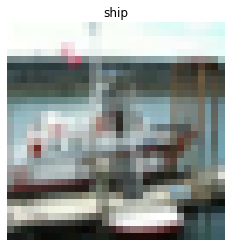

Training set ground truth has shape: (50000, 32, 32, 3)
Test set ground truth has shape: (10000, 32, 32, 3)
Width and Height of training and test data should be: (32, 32, 3)
Training set has shape: (50000, 16, 16, 3)
Test set has shape: (10000, 16, 16, 3)


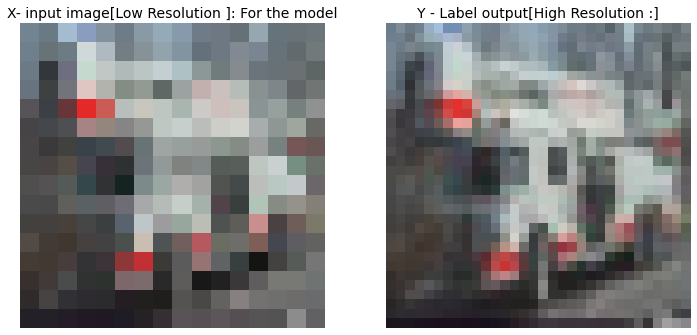

We can the see difference in the images as img on left(Low Resolution) is half the size of one on right.
We will need to upscale the image to create the interpolated low resoltuion image to be feed into the network
Left Image size: (50000, 16, 16, 3)
Right Image size (50000, 32, 32, 3)


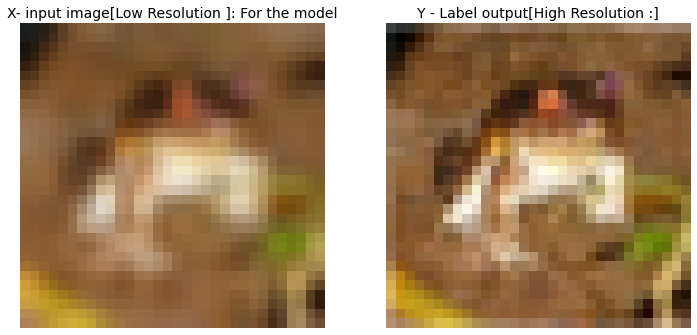

After upscaling the input images:
Train data shape: (40000, 32, 32, 3)
Train label shape: (40000, 32, 32, 3)
Vali data shape: (10000, 32, 32, 3)
Vali label shape: (10000, 32, 32, 3)
Test data shape: (10000, 32, 32, 3)
Test label shape: (10000, 32, 32, 3)


In [8]:
data,data_label,vali_data,vali_label,test,test_label=load_cifar(2)

## Creating a model with 5 layers

In [9]:
input_dim = data_label.shape[1:]
print(input_dim)
cifar_l5 =vdsr(input_dim,5)
cifar_l5.summary()

(32, 32, 3)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 34, 34, 3)   0           ['input[0][0]']                  
                                                                                                  
 CONV1 (Conv2D)                 (None, 32, 32, 64)   1792        ['zero_padding2d[0][0]']         
                                                                                                  
 re_lu (ReLU)                   (None, 32, 32, 64)   0           ['CONV1[0][0]']                  
                                                                                  

Using model.fit() to claclulate results

Epoch 1/10
625/625 [==============================] - 23s 17ms/step - loss: 0.0025 - accuracy: 0.9298 - val_loss: 0.0023 - val_accuracy: 0.9301
Epoch 2/10
625/625 [==============================] - 10s 16ms/step - loss: 0.0023 - accuracy: 0.9298 - val_loss: 0.0022 - val_accuracy: 0.9301
Epoch 3/10
625/625 [==============================] - 10s 16ms/step - loss: 0.0022 - accuracy: 0.9298 - val_loss: 0.0022 - val_accuracy: 0.9301
Epoch 4/10
625/625 [==============================] - 10s 16ms/step - loss: 0.0022 - accuracy: 0.9298 - val_loss: 0.0022 - val_accuracy: 0.9301
Epoch 5/10
625/625 [==============================] - 10s 16ms/step - loss: 0.0022 - accuracy: 0.9298 - val_loss: 0.0022 - val_accuracy: 0.9301
Epoch 6/10
625/625 [==============================] - 10s 16ms/step - loss: 0.0022 - accuracy: 0.9298 - val_loss: 0.0021 - val_accuracy: 0.9301
Epoch 7/10
625/625 [==============================] - 10s 16ms/step - loss: 0.0022 - accuracy: 0.9298 - val_loss: 0.0021 - val_accuracy:

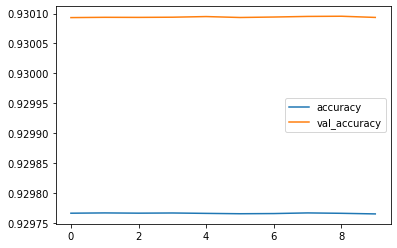

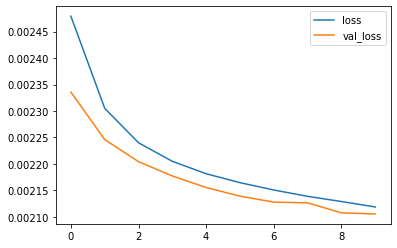

In [10]:
cifar_l5.compile(optimizer=Adam(learning_rate=0.0001,beta_1=0.9), loss='mse', metrics=['accuracy'])
result_cifar_l5 = cifar_l5.fit(data,data_label, batch_size=64, epochs=10, validation_data=(vali_data,vali_label))
plot(result_cifar_l5)

Calculating predictions

In [11]:
y_pred = cifar_l5.predict(test)

313/313 [==============================] - 1s 3ms/step


Calculating PSNR Values for every prediction

In [12]:
cifar_l5_psnr = PSNR(test_label,y_pred)

Ploting a graph for PSNR values and printing the max,min and avg values

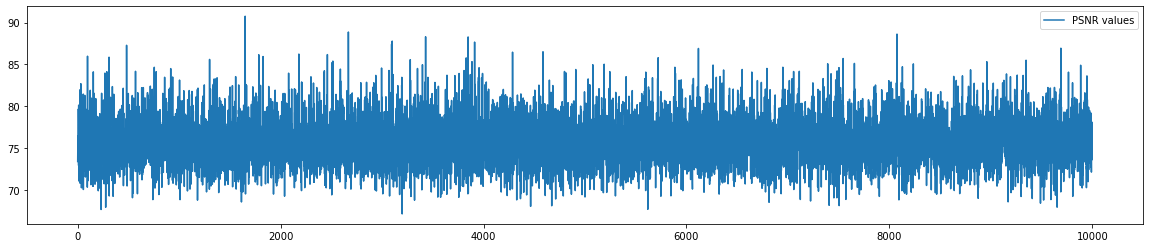

Maximum psnr value: 90.75793099593488
Minimum PSNR value: 67.10327293532522
Average PSNR value: 75.71551563253736


In [13]:
plot_psnr(cifar_l5_psnr)

Plotting the output

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


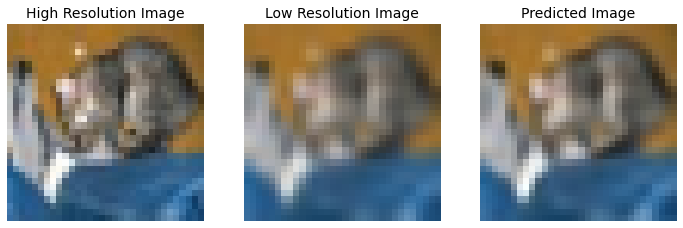

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PSNR value 73.37904031693259


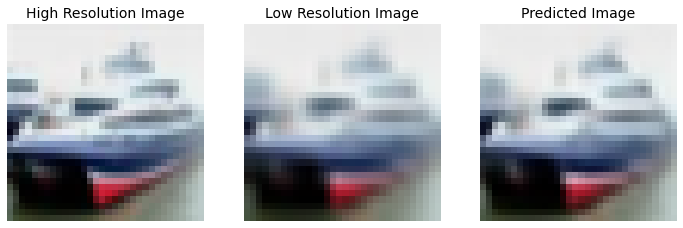

PSNR value 74.27174695433888


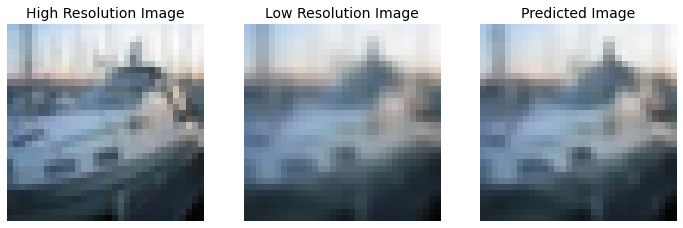

PSNR value 76.0954141151014


In [14]:
plot_output(test_label,test,y_pred,cifar_l5_psnr)

## Creating model with 10 layers

In [17]:
def model10(inp):
    lr = Input(shape=(inp))
    c1 = Conv2D(64,(3,3), padding='same')(lr)
    r1 = ReLU()(c1)
    c2 = Conv2D(64,(3,3), padding='same')(r1)
    r2 = ReLU()(c2)
    c3 = Conv2D(64,(3,3), padding='same')(r2)
    r3 = ReLU()(c3)
    c4 = Conv2D(64,(3,3), padding='same')(r3)
    r4 = ReLU()(c4)
    c5 = Conv2D(64,(3,3), padding='same')(r4)
    r5 = ReLU()(c5)
    c6 = Conv2D(64,(3,3),padding='same')(r5)
    r6 = ReLU()(c6)
    c7 = Conv2D(64,(3,3),padding='same')(r6)
    r7 = ReLU()(c7)
    c8 = Conv2D(64,(3,3),padding='same')(r7)
    r8 = ReLU()(c8)
    c9 = Conv2D(64,(3,3),padding='same')(r8)
    r10 = ReLU()(c9)
    r = Conv2D(1,(3,3), padding='same')(r10)
    out = Add()([lr,r])
    return Model(lr,out)

In [18]:
cifar_l10 = model10(input_dim)
cifar_l10.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_5 (Conv2D)              (None, 32, 32, 64)   1792        ['input_2[0][0]']                
                                                                                                  
 re_lu_8 (ReLU)                 (None, 32, 32, 64)   0           ['conv2d_5[0][0]']               
                                                                                                  
 conv2d_6 (Conv2D)              (None, 32, 32, 64)   36928       ['re_lu_8[0][0]']                
                                                                                            

Training the model

Epoch 1/10
625/625 [==============================] - 19s 29ms/step - loss: 0.0024 - accuracy: 0.9298 - val_loss: 0.0023 - val_accuracy: 0.9301
Epoch 2/10
625/625 [==============================] - 18s 29ms/step - loss: 0.0022 - accuracy: 0.9298 - val_loss: 0.0022 - val_accuracy: 0.9301
Epoch 3/10
625/625 [==============================] - 18s 29ms/step - loss: 0.0022 - accuracy: 0.9298 - val_loss: 0.0021 - val_accuracy: 0.9301
Epoch 4/10
625/625 [==============================] - 18s 29ms/step - loss: 0.0021 - accuracy: 0.9298 - val_loss: 0.0021 - val_accuracy: 0.9301
Epoch 5/10
625/625 [==============================] - 18s 29ms/step - loss: 0.0021 - accuracy: 0.9298 - val_loss: 0.0021 - val_accuracy: 0.9301
Epoch 6/10
625/625 [==============================] - 18s 29ms/step - loss: 0.0021 - accuracy: 0.9298 - val_loss: 0.0021 - val_accuracy: 0.9301
Epoch 7/10
625/625 [==============================] - 18s 29ms/step - loss: 0.0021 - accuracy: 0.9298 - val_loss: 0.0021 - val_accuracy:

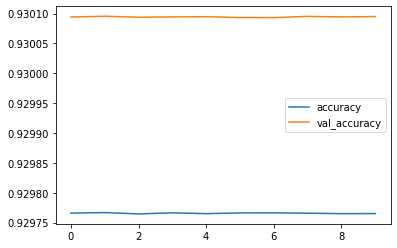

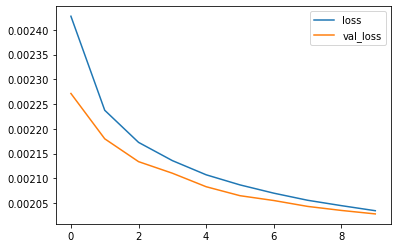

In [19]:
cifar_l10.compile(optimizer=Adam(learning_rate=0.0001,beta_1=0.9), loss='mse', metrics=['accuracy'])
result_cifar_l10 = cifar_l10.fit(data,data_label, batch_size=64, epochs=10, validation_data=(vali_data,vali_label))
plot(result_cifar_l10)

Predictions, PSNR values, Plotting PSNR values and plotting output

313/313 [==============================] - 2s 6ms/step


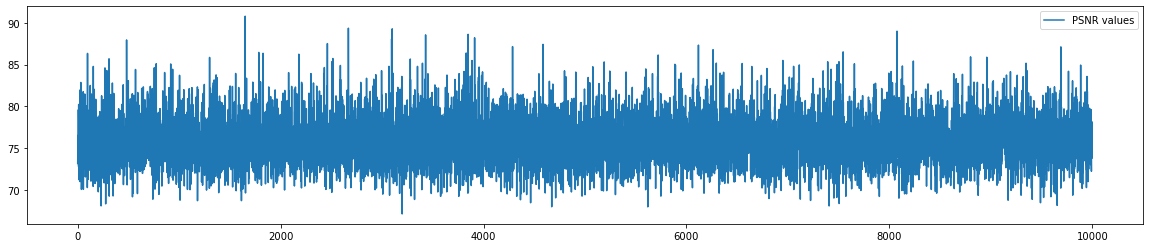

Maximum psnr value: 90.77963159850285
Minimum PSNR value: 67.16190871738924
Average PSNR value: 75.88647588521926


In [20]:
cifar_l10_pred = cifar_l10.predict(test)
cifar_l10_psnr = PSNR(test_label,cifar_l10_pred)
plot_psnr(cifar_l10_psnr)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


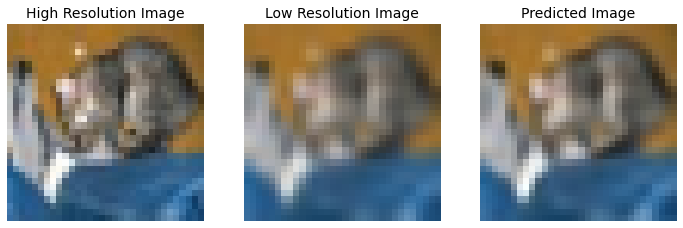

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PSNR value 73.18976305329967


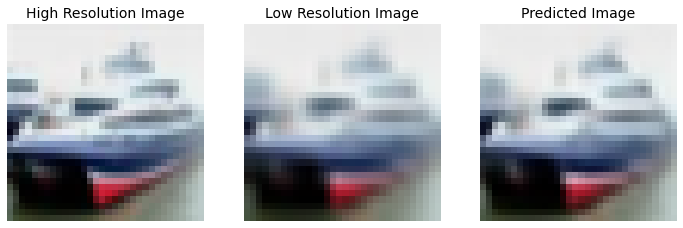

PSNR value 74.10565829635279


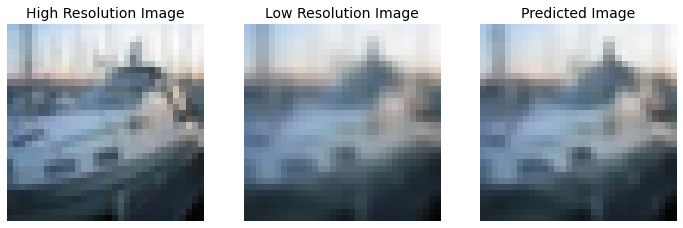

PSNR value 76.1984259454641


In [22]:
plot_output(test_label,test,y_pred,cifar_l10_psnr)